In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import KFold
import xgboost as xgb

plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'cuda'

In [2]:
# Load data
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_test_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_test_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_test_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_test_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_test_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [3]:
def train_xgb_model_with_f2_score(train_df, test_df, model_path, scaler_path):
    train_data = train_df.copy()
    test_data = test_df.copy()
    
    y_train = train_data.pop('source')  # 假設標籤列名為 'source'
    y_test = test_data.pop('source')  # 假設標籤列名為 'source'

    # 標準化數據
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.values)
    X_test_scaled = scaler.transform(test_data.values)
    
    # 保存標準化器
    with gzip.open(scaler_path, 'wb') as f:
        joblib.dump(scaler, f)

    # 10折交叉驗證
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    confusion_matrices = []
    f2_scores = []
    best_model = None
    best_f2_score = float('-inf')

    for train_index, test_index in kf.split(X_train_scaled):
        fold += 1
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # 建立 XGBoost 模型
        model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, gpu_id=0 if device == "gpu" else -1)
        
        # 訓練模型
        model.fit(X_train, y_train_fold, eval_set=[(X_val, y_val_fold)], verbose=False, early_stopping_rounds=10)

        # 測試模型並計算F2 score
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        cm_train = confusion_matrix(y_train_fold, y_pred_train)
        cm_test = confusion_matrix(y_val_fold, y_pred_val)
        confusion_matrices.append((cm_train, cm_test))

        f2 = fbeta_score(y_val_fold, y_pred_val, beta=2)
        f2_scores.append(f2)

        # 保存最佳模型
        if f2 > best_f2_score:
            best_f2_score = f2
            best_model = model

    # 計算平均F2-score
    avg_f2_score = sum(f2_scores) / len(f2_scores)
    print(f'Average F2 Score: {avg_f2_score:.4f}')

    # 計算混淆矩陣加總再標準化
    sum_cm_train = sum([cm[0] for cm in confusion_matrices])
    sum_cm_val = sum([cm[1] for cm in confusion_matrices])

    norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
    norm_cm_val = sum_cm_val.astype('float') / sum_cm_val.sum(axis=1)[:, np.newaxis]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Normalized Confusion Matrices')

    sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
    axs[0].set_title('Normalized Train Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    sns.heatmap(norm_cm_val, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
    axs[1].set_title('Normalized Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # 保存最佳模型
    with gzip.open(model_path, 'wb') as f:
        joblib.dump(best_model, f)

    # 評估validation set
    y_test_pred = best_model.predict(X_test_scaled)
    test_cm = confusion_matrix(y_test, y_test_pred)
    test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)

    print(f'Test F2 Score: {test_f2_score:.4f}')

    norm_test_cm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 5))
    sns.heatmap(norm_test_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Testing Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [08:30:45] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility w

Average F2 Score: 0.9908


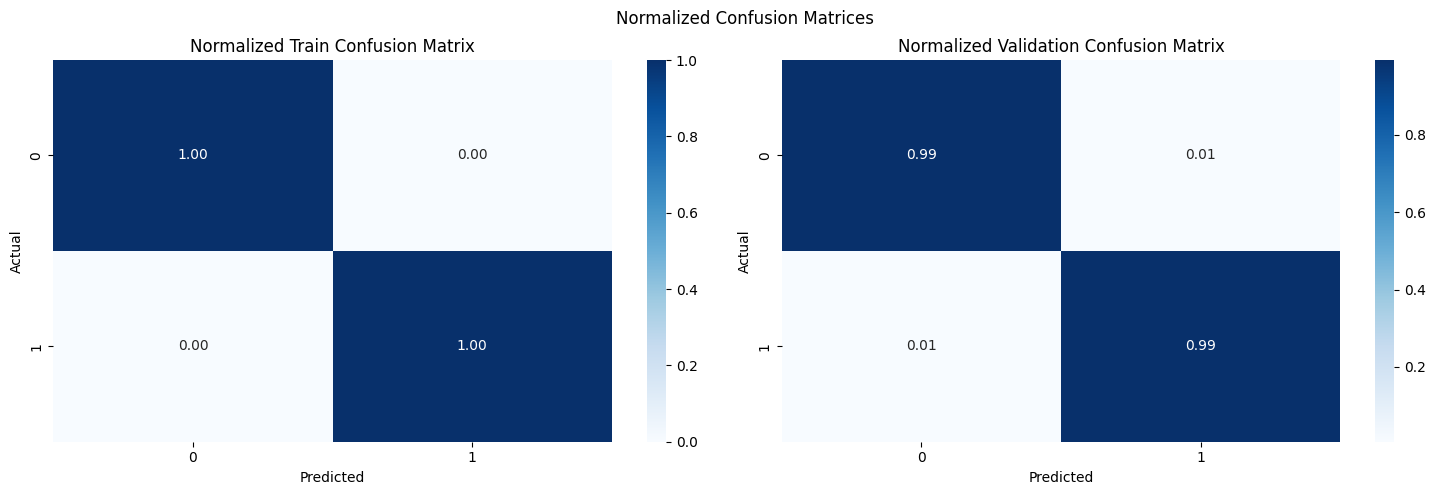

Test F2 Score: 1.0000


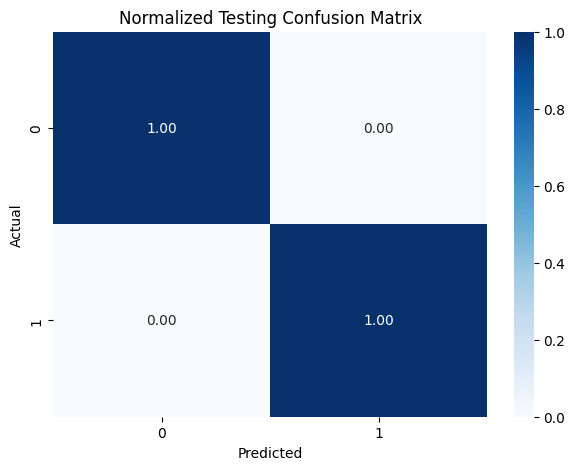

In [4]:
train_xgb_model_with_f2_score(tfidf_train_data, tfidf_test_data, '../Data/Model/tfidf_xgb_10fold_model.pth.gz', '../Data/Model/tfidf_10fold_scaler.pkl.gz')

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibi

Average F2 Score: 0.9825


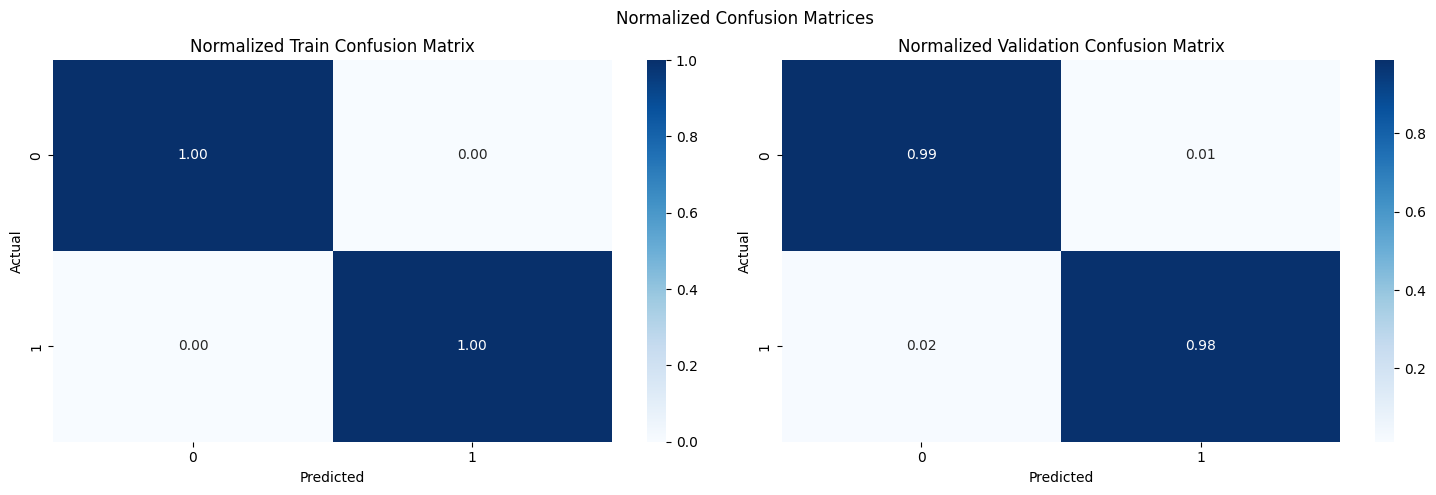

Test F2 Score: 0.9893


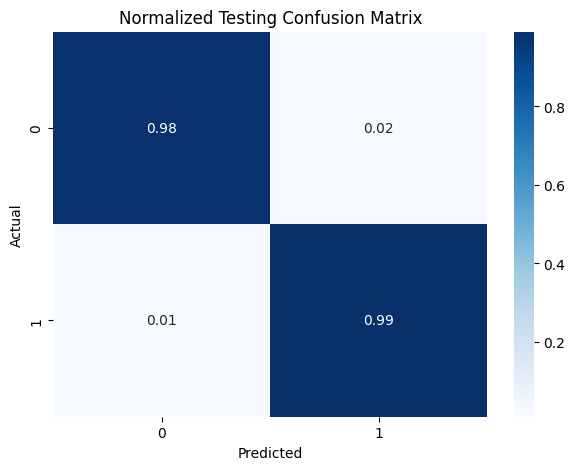

In [5]:
train_xgb_model_with_f2_score(word2vec_selftrain_train_data, word2vec_selftrain_test_data, '../Data/Model/word2vec_selftrain_xgb_10fold_model.pth.gz', '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz')

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibi

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibi

Average F2 Score: 0.9774


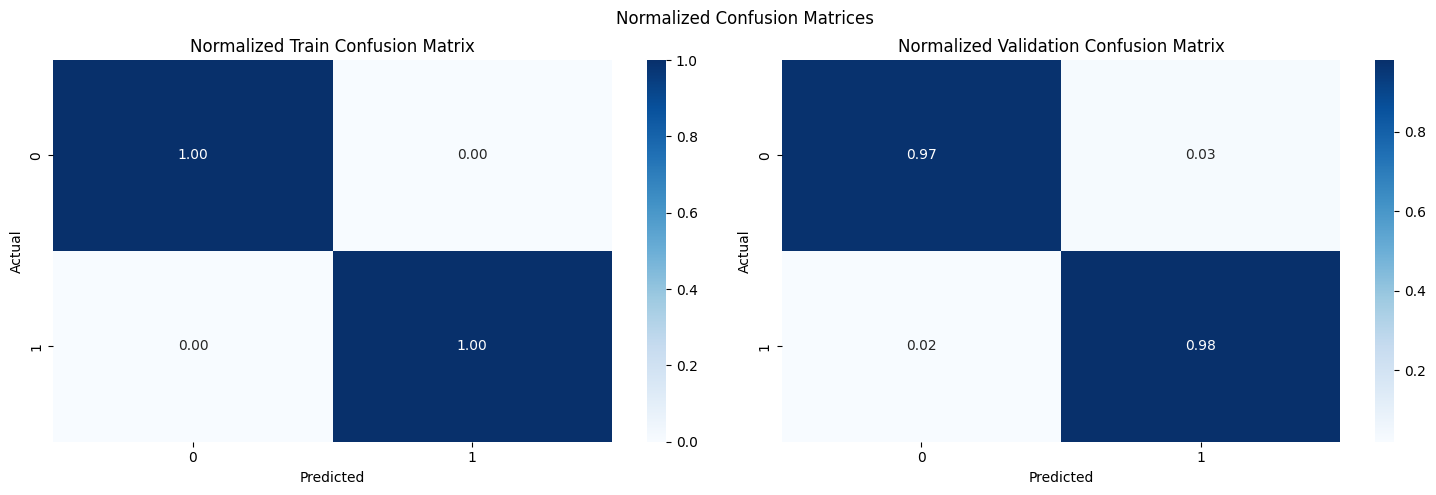

Test F2 Score: 0.9737


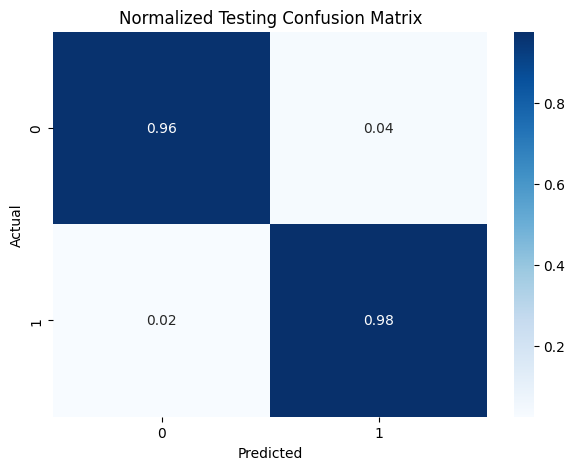

In [6]:
train_xgb_model_with_f2_score(word2vec_train_data, word2vec_test_data, '../Data/Model/word2vec_xgb_10fold_model.pth.gz', '../Data/Model/word2vec_10fold_scaler.pkl.gz')

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibi

Average F2 Score: 0.9909


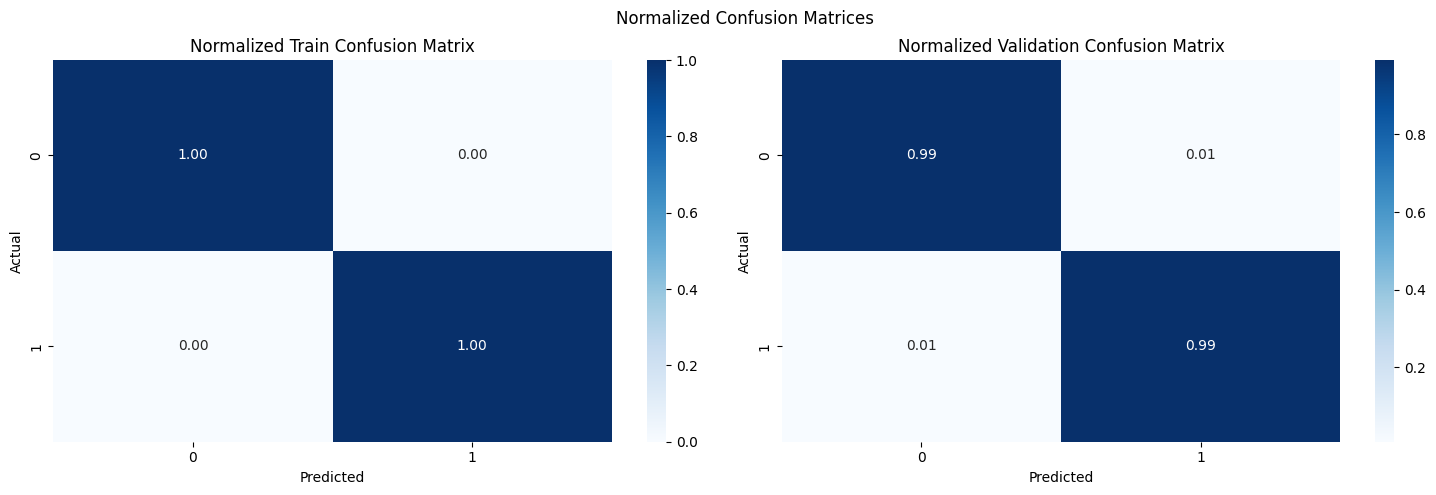

Test F2 Score: 0.9951


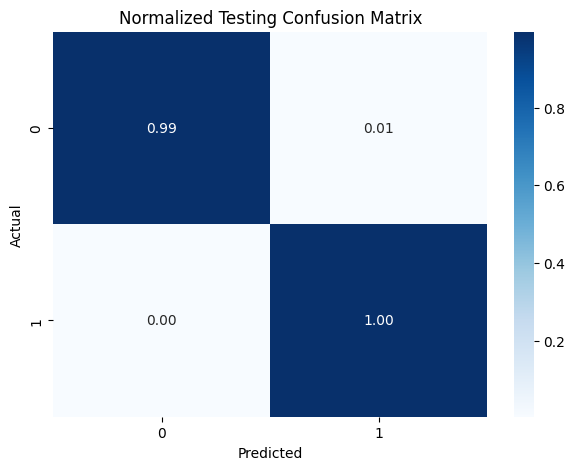

In [7]:
train_xgb_model_with_f2_score(bert_selftrain_train_data, bert_selftrain_test_data, '../Data/Model/bert_selftrain_xgb_10fold_model.pth.gz', '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz')

/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/catherine/env_catherine/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibi

Average F2 Score: 0.9909


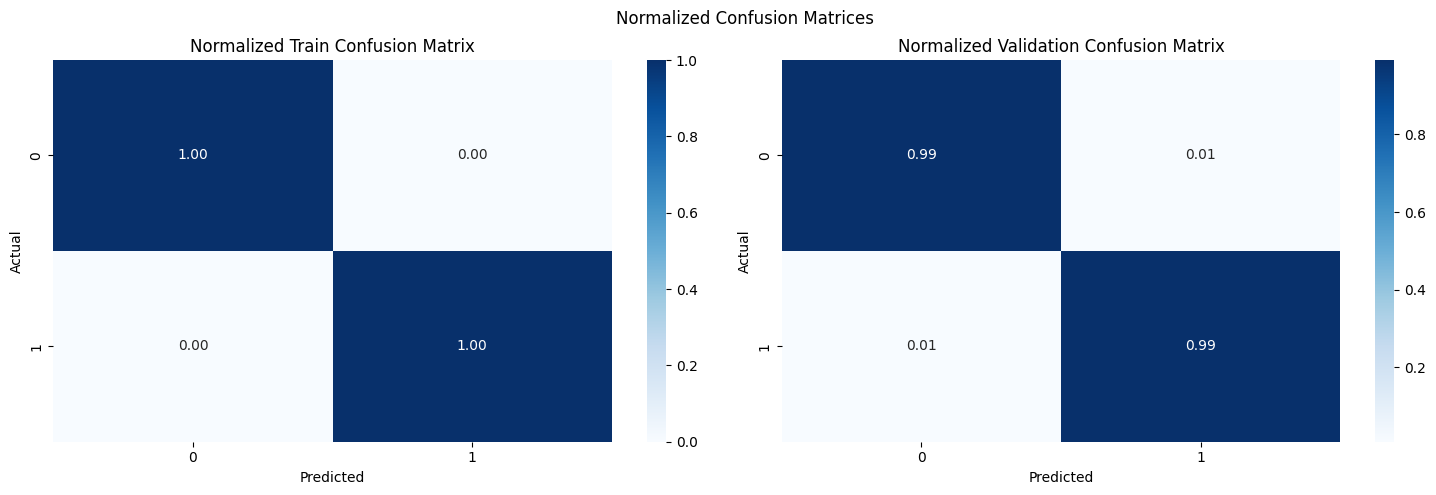

Test F2 Score: 0.9951


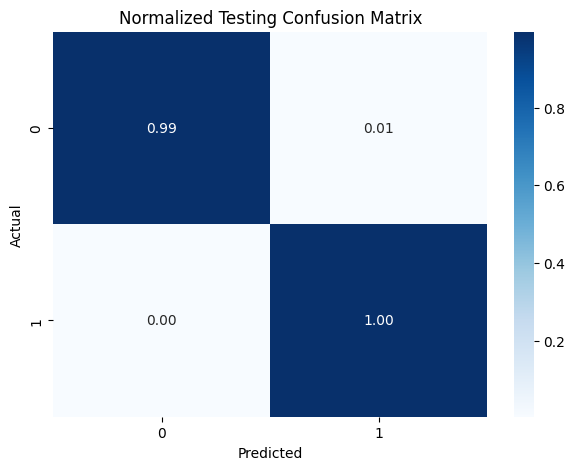

In [8]:
train_xgb_model_with_f2_score(bert_train_data, bert_test_data, '../Data/Model/bert_xgb_10fold_model.pth.gz', '../Data/Model/bert_10fold_scaler.pkl.gz')